In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import skimage
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import torch
import pickle
import glob
from skimage.color import label2rgb

import warnings
warnings.filterwarnings('ignore', message='overflow encountered in exp')

In [2]:
# https://stackoverflow.com/questions/66595055/fastest-way-of-computing-binary-mask-iou-with-numpy
def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = torch.logical_or(mask1, mask2).to(torch.int).sum()
    return intersection / union

In [3]:
np.random.seed(0)

image_numbers = glob.glob("data/cell_seg/cellpose_test_greyscale/*_img.png")
image_numbers = np.random.permutation(image_numbers)

T_values = np.arange(-5, 5.01, 1)

In [4]:
# from https://github.com/MouseLand/cellpose/blob/main/notebooks/test_Cellpose-SAM.ipynb

from cellpose import models, core, io, plot, transforms
from pathlib import Path
from tqdm import trange

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.13.2 
torch version:  	2.8.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-09-29 18:19:49,192 [INFO] WRITING LOG OUTPUT TO /home/kerrilu/.cellpose/run.log
2025-09-29 18:19:49,193 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.13.2 
torch version:  	2.8.0+cu126
2025-09-29 18:19:50,471 [INFO] ** TORCH CUDA version installed and working. **
2025-09-29 18:19:50,472 [INFO] ** TORCH CUDA version installed and working. **
2025-09-29 18:19:50,473 [INFO] >>>> using GPU (CUDA)
2025-09-29 18:19:53,294 [INFO] >>>> loading model /home/kerrilu/.cellpose/models/cpsam


In [5]:
def detect_cells(img, T):
    masks, flows, styles = model.eval(img, cellprob_threshold=T)
    return masks, flows, styles

In [6]:
import itertools
def compute_pair_to_iou_dict(masks):
    indices = np.arange(len(masks))
    pairs = itertools.combinations(indices, 2)
    pair_to_iou = {}
    for pair in pairs:
        i, j = pair
        if masks[i].sum()==0 or masks[j].sum()==0:
            pair_to_iou[tuple(pair)] = 0
        else:
            pair_to_iou[tuple(pair)] = iou(masks[i], masks[j]).numpy()
    return pair_to_iou

def remove_duplicate_masks(indices, pair_to_iou, iou_threshold=0.95):
    for k in np.arange(1, len(indices)+1):
        for new_indices in itertools.combinations(indices, k):
            removed_indices = list(set(indices) - set(new_indices))
            valid_combination = True
            for i in removed_indices:
                new_indices_contain_similar_mask = False
                for j in new_indices:
                    if pair_to_iou[tuple(sorted((i, j)))] > iou_threshold:
                        new_indices_contain_similar_mask = True
                        break
                if not new_indices_contain_similar_mask:
                    valid_combination = False
                    break
            if valid_combination:
                return list(new_indices)

# Calibrate conformal algorithm

In [88]:
np.random.seed(0)

#image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers):
    img = io.imread(image_number)[...,1]
    #resize_factor = image_size/(max(img.shape))
    #img = transforms.resize_image(img, rsz=resize_factor)[...,1] # resize image so that the longest side has length 256 pixels
    
    true_segmentation = io.imread(image_number[:-7]+'masks.png')#[..., np.newaxis]
    #true_segmentation = transforms.resize_image(true_segmentation, rsz=resize_factor)
    
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for T in T_values:
            pred_segmentation, _, _ = detect_cells(img, T)
            IOUs_T = []
            for coord in coords:
                if pred_segmentation[coord] == 0:
                    IOU = 0 # the pixel is predicted to be a non-cell
                else:
                    true_shape = true_segmentation==true_segmentation[coord]
                    pred_shape = pred_segmentation==pred_segmentation[coord]
                    IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape)).numpy().item()
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).T.tolist())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [3:02:06<00:00, 210.13s/it]


In [89]:
results_table = pd.DataFrame.from_dict(results)
results_table

image_number       coord  \
0     data/cell_seg/cellpose_test_greyscale/044_img.png   (172, 53)   
1     data/cell_seg/cellpose_test_greyscale/044_img.png    (47, 38)   
2     data/cell_seg/cellpose_test_greyscale/044_img.png  (117, 244)   
3     data/cell_seg/cellpose_test_greyscale/044_img.png   (67, 105)   
4     data/cell_seg/cellpose_test_greyscale/044_img.png   (103, 42)   
...                                                 ...         ...   
1575  data/cell_seg/cellpose_test_greyscale/060_img.png  (234, 421)   
1576  data/cell_seg/cellpose_test_greyscale/060_img.png  (283, 440)   
1577  data/cell_seg/cellpose_test_greyscale/060_img.png  (399, 203)   
1578  data/cell_seg/cellpose_test_greyscale/060_img.png  (297, 188)   
1579  data/cell_seg/cellpose_test_greyscale/060_img.png    (6, 101)   

                                                   IOUs  
0     [0.7663934230804443, 0.77379310131073, 0.78902...  
1     [0.8606124520301819, 0.8606124520301819, 0.860...  
2     [0.005891016218811274, 0.005891016218811274, 0...  
3     [0.44285714626312256, 0.44285714626312256, 0.4...  
4     [0.8606557250022888, 0.8606557250022888, 0.860...  
...                                                 ...  
1575  [0.9119359254837036, 0.9126001596450806, 0.921...  
1576  [0.8989384174346924, 0.8989384174346924, 0.908...  
1577  [0.9214131236076355, 0.9250814318656921, 0.930...  
1578  [0.8909198045730591, 0.8932899832725525, 0.901...  
1579  [0.906410276889801, 0.906410276889801, 0.90641...  

[1580 rows x 3 columns]

In [90]:
file = open('data/cell_seg/conformal_ious_cellpose_SAM.pkl', 'wb')
pickle.dump(results_table, file)
file.close()

# Compute conformal confidence interval for threshold T

In [7]:
file = open('data/cell_seg/conformal_ious_cellpose_SAM.pkl', 'rb')
results_table = pickle.load(file)
file.close()

image_numbers_calibration = image_numbers[:30]
image_numbers_test = image_numbers[30:]
results_table = results_table[results_table['image_number'].isin(image_numbers_calibration)]

In [8]:
IOU_threshold = 0.75

def compute_Ts_with_high_IOU(IOUs):
    indices_with_high_IOU = np.argwhere(np.array(IOUs) >= IOU_threshold)[:, 0]
    return T_values[indices_with_high_IOU]

def find_T_min(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_min = Ts_with_high_IOU[0]
        return T_min
    
def find_T_max(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_max = Ts_with_high_IOU[-1]
        return T_max
    
def find_T_median(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_median = np.percentile(Ts_with_high_IOU, 50, interpolation='lower')
        return T_median

results_table["max IOU"] = results_table["IOUs"].map(lambda x: np.max(x))
results_table["Ts with high IOU"] = results_table["IOUs"].map(compute_Ts_with_high_IOU)
results_table["T min"] = results_table["Ts with high IOU"].map(find_T_min)
results_table["T max"] = results_table["Ts with high IOU"].map(find_T_max)
results_table["T median"] = results_table["Ts with high IOU"].map(find_T_median)
results_table

image_number       coord  \
0    data/cell_seg/cellpose_test_greyscale/044_img.png   (172, 53)   
1    data/cell_seg/cellpose_test_greyscale/044_img.png    (47, 38)   
2    data/cell_seg/cellpose_test_greyscale/044_img.png  (117, 244)   
3    data/cell_seg/cellpose_test_greyscale/044_img.png   (67, 105)   
4    data/cell_seg/cellpose_test_greyscale/044_img.png   (103, 42)   
..                                                 ...         ...   
920  data/cell_seg/cellpose_test_greyscale/061_img.png  (324, 256)   
921  data/cell_seg/cellpose_test_greyscale/061_img.png   (95, 197)   
922  data/cell_seg/cellpose_test_greyscale/061_img.png  (106, 233)   
923  data/cell_seg/cellpose_test_greyscale/061_img.png  (242, 353)   
924  data/cell_seg/cellpose_test_greyscale/061_img.png   (91, 177)   

                                                  IOUs   max IOU  \
0    [0.7663934230804443, 0.77379310131073, 0.78902...  0.824742   
1    [0.8606124520301819, 0.8606124520301819, 0.860...  0.860612   
2    [0.005891016218811274, 0.005891016218811274, 0...  0.005997   
3    [0.44285714626312256, 0.44285714626312256, 0.4...  0.750000   
4    [0.8606557250022888, 0.8606557250022888, 0.860...  0.861644   
..                                                 ...       ...   
920  [0.8874552249908447, 0.8874552249908447, 0.906...  0.941762   
921  [0.7653316855430603, 0.7653316855430603, 0.765...  0.833087   
922  [0.8950704336166382, 0.8950704336166382, 0.895...  0.925057   
923  [0.731812596321106, 0.731812596321106, 0.74048...  0.935563   
924  [0.7653316855430603, 0.7653316855430603, 0.765...  0.833087   

                                      Ts with high IOU  T min  T max  T median  
0    [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    3.0      -1.0  
1    [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    4.0      -1.0  
2                                                   []    NaN    NaN       NaN  
3                                                [4.0]    4.0    4.0       4.0  
4    [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    4.0      -1.0  
..                                                 ...    ...    ...       ...  
920  [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    4.0      -1.0  
921  [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    3.0      -1.0  
922  [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    5.0       0.0  
923                        [-2.0, -1.0, 0.0, 1.0, 2.0]   -2.0    2.0       0.0  
924  [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...   -5.0    5.0       0.0  

[925 rows x 8 columns]

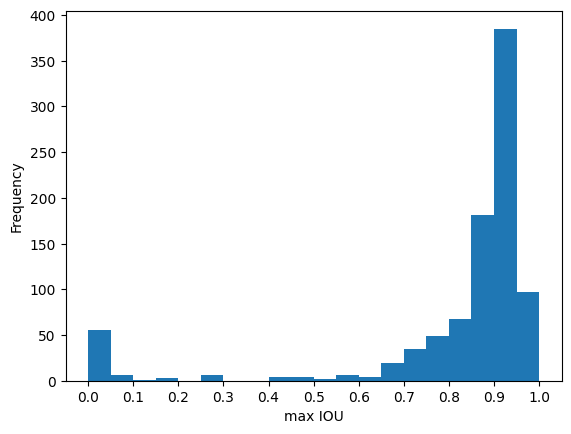

In [9]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

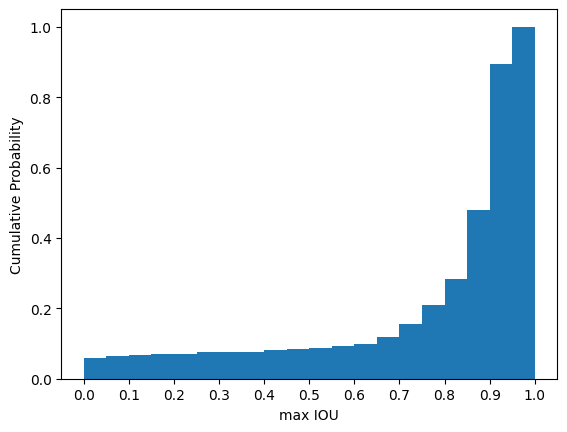

In [10]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

# Find T values for confidence set

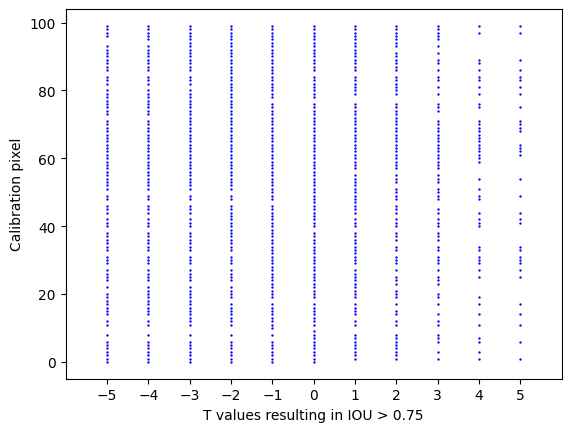

In [13]:
np.random.seed(0)

results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
results_table_high_IOUs = results_table_high_IOUs.sample(n=100)
Ts_with_high_IOU = np.array(results_table_high_IOUs["Ts with high IOU"])

for i in range(len(Ts_with_high_IOU)):
    xs = Ts_with_high_IOU[i]
    ys = np.repeat(i, len(xs))
    plt.scatter(xs, ys, color='blue', s=0.5)
    plt.xlabel(f"T values resulting in IOU > {IOU_threshold}")
    plt.ylabel("Calibration pixel")
    plt.xticks(np.arange(-5, 5.01, 1))
    plt.xlim(-6, 6)

In [14]:
import itertools
import math

alpha = .2
results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
p = 1 - len(results_table_high_IOUs) / len(results_table)
print(p)
if p > alpha:
    print("too uncertain")
else:
    IOUs = np.array([np.array(x) for x in results_table["IOUs"]])
    IOUs_high = (IOUs>IOU_threshold).astype(int)
    T_confidence_set = []
    num_calibration_pixels_covered = 0
    num_calibration_pixels_target = (1-alpha)*len(results_table)
    while num_calibration_pixels_covered < num_calibration_pixels_target:
        coverage_by_T = IOUs_high.sum(axis=0)
        best_T = np.argmax(coverage_by_T)
        calibration_pixels_covered = np.argwhere(IOUs_high[:, best_T]==1)
        IOUs_high = np.delete(IOUs_high, calibration_pixels_covered, axis=0)
        
        T_confidence_set.append(best_T)
        num_calibration_pixels_covered += np.max(coverage_by_T)

        print(T_values[best_T])
        print("Percent of calibration pixels covered so far:", num_calibration_pixels_covered/len(results_table))
    
    T_confidence_set = T_values[np.sort(T_confidence_set)]
    print("Greedy algorithm output:", T_confidence_set)

    IOUs_high = (IOUs>IOU_threshold).astype(int)
    n = IOUs_high.shape[1]
    indices = np.arange(n)
    m = len(T_confidence_set)
    for k in np.arange(2, m):
        print("Trying subsets of size", k)
        for indices_subset in tqdm(itertools.combinations(indices, k), total=math.comb(n,k)):
            IOUs_high_subset = IOUs_high[:, indices_subset]
            num_calibration_pixels_covered = (IOUs_high_subset.sum(axis=1) > 0).sum(axis=0)
            if num_calibration_pixels_covered >= num_calibration_pixels_target:
                T_confidence_set = np.sort(T_values[np.array(indices_subset)])
                break
        if num_calibration_pixels_covered >= num_calibration_pixels_target:
            break
                
    print("Final output:", T_confidence_set)

0.15891891891891896
0.0
Percent of calibration pixels covered so far: 0.7945945945945946
-2.0
Percent of calibration pixels covered so far: 0.8216216216216217
Greedy algorithm output: [-2.  0.]
Final output: [-2.  0.]


# Investigate low IOUs

data/cell_seg/cellpose_test_greyscale/053_img.png


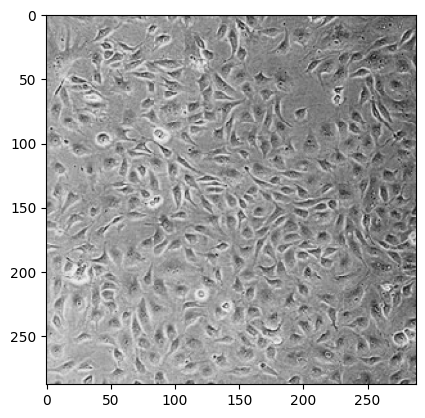

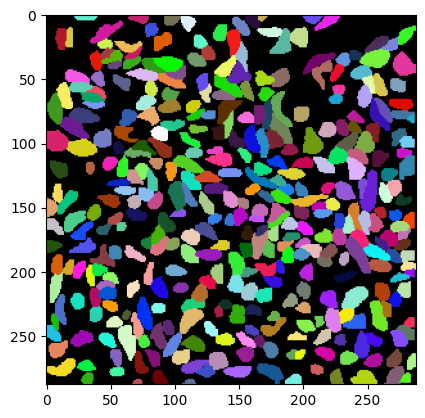

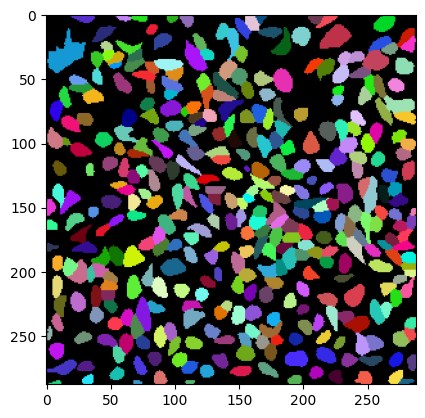

data/cell_seg/cellpose_test_greyscale/065_img.png


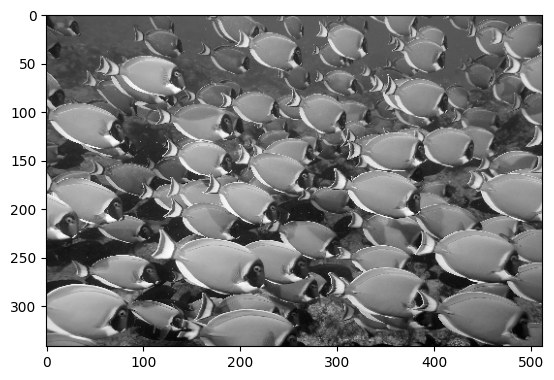

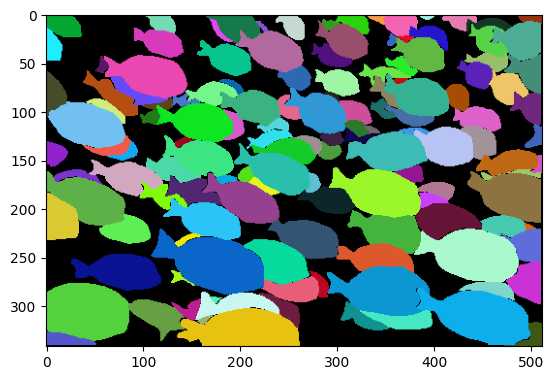

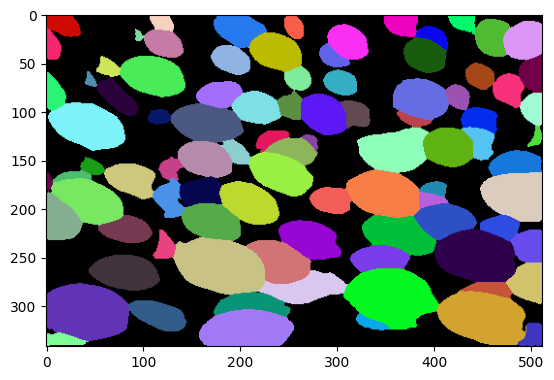

data/cell_seg/cellpose_test_greyscale/014_img.png


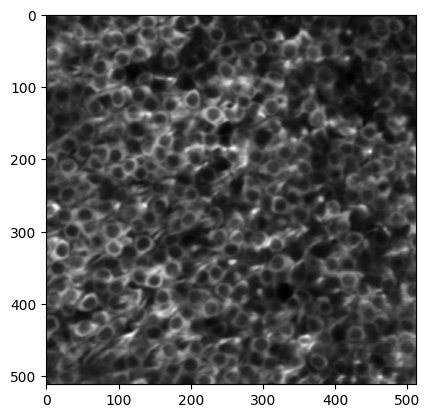

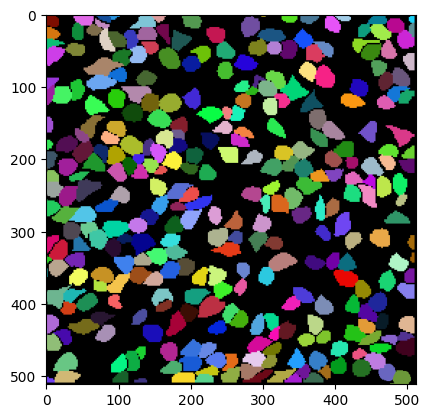

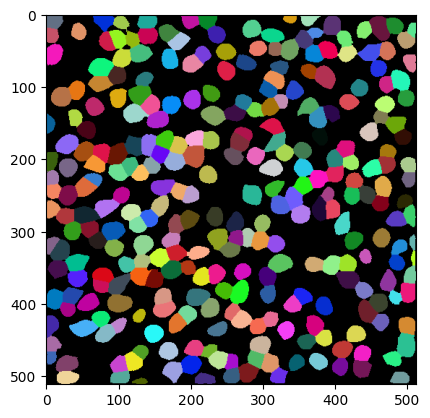

data/cell_seg/cellpose_test_greyscale/032_img.png


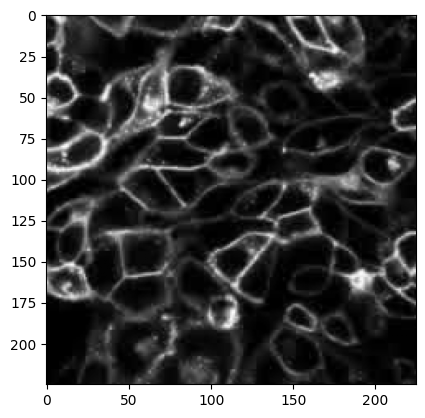

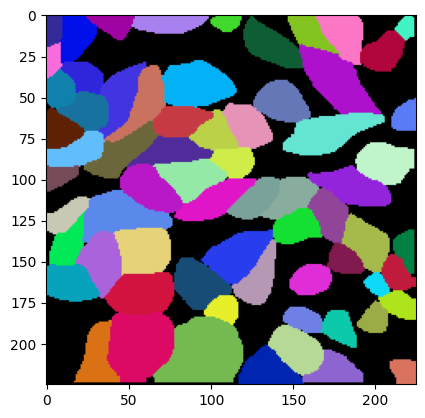

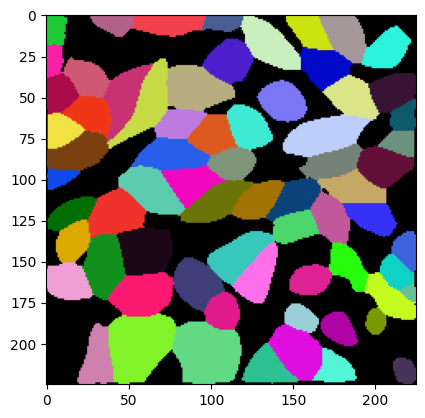

data/cell_seg/cellpose_test_greyscale/023_img.png


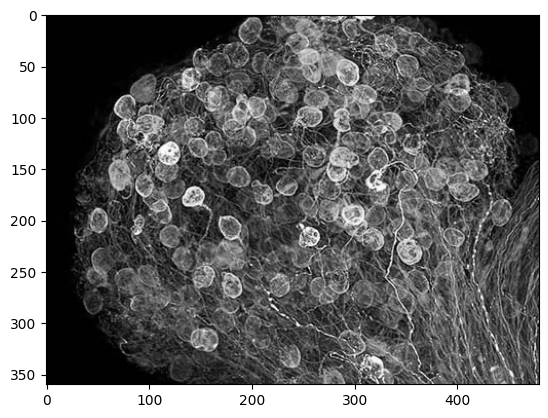

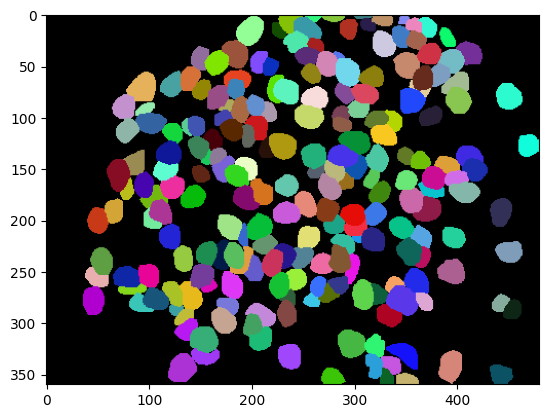

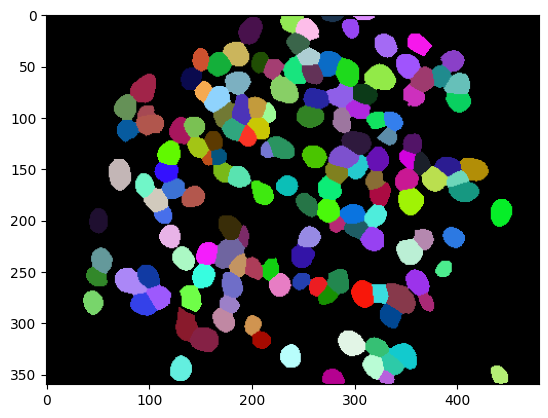

In [13]:
results_table_low_IOUs = results_table[results_table["max IOU"] < IOU_threshold]
for image_number in results_table_low_IOUs["image_number"].value_counts().head(5).index:
    print(image_number)
    
    img = io.imread(image_number)[...,1]
    fig = plt.figure(frameon=False) # initialize figure
    plt.imshow(img,cmap='gray')
    plt.show()
    
    #print("True Segmentation")
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    unique_labels = np.unique(true_segmentation)
    colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
    true_segmentation = label2rgb(true_segmentation, bg_label=0, bg_color=(0, 0, 0), colors=colors)
    plt.imshow(true_segmentation)
    plt.show()
    
    #print("Predicted Segmentation (T=0)")
    for T in [0]:
        pred_segmentation, _, _ = detect_cells(img, T)
        unique_labels = np.unique(pred_segmentation)
        colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
        pred_segmentation = label2rgb(pred_segmentation, colors=colors)
        plt.imshow(pred_segmentation)
        plt.show()

# Remove duplicate predicted masks for test images

In [16]:
np.random.seed(0)

points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": [], "Classified as Cell": []}
for image_number in tqdm(image_numbers_test):
    img = io.imread(image_number)[...,1]
    
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    pred_shapes = []
    classified_as_cell = []
    if len(coords) != 0:
        for T in T_confidence_set:
            pred_segmentation, _, _ = detect_cells(img, T)
            IOUs_T = []
            pred_shapes_T = []
            classified_as_cell_T = []
            for coord in coords:
                if pred_segmentation[coord] == 0:
                    IOU = 0 # the pixel is predicted to be a non-cell
                    pred_shape = torch.zeros(img.shape)
                    classified_as_cell_T.append(False)
                else:
                    true_shape = true_segmentation==true_segmentation[coord]
                    pred_shape = pred_segmentation==pred_segmentation[coord]
                    IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape)).numpy().item()
                    classified_as_cell_T.append(True)
                pred_shapes_T.append(pred_shape)
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
            pred_shapes.append(pred_shapes_T)
            classified_as_cell.append(classified_as_cell_T)
            
        pair_to_iou_dicts = []
        for pred_shapes_coord in torch.from_numpy(np.swapaxes(pred_shapes, 0, 1)):
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
        # store results
        results["image_number"].extend(np.repeat(image_number, len(coords)))
        results["coord"].extend(coords)
        results["IOUs"].extend(np.array(IOUs).T.tolist())
        results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)
        results["Classified as Cell"].extend(np.array(classified_as_cell).T.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [05:58<00:00, 16.28s/it]


In [17]:
results_table_test = pd.DataFrame.from_dict(results)
results_table_test

image_number       coord  \
0    data/cell_seg/cellpose_test_greyscale/024_img.png  (211, 151)   
1    data/cell_seg/cellpose_test_greyscale/024_img.png  (292, 183)   
2    data/cell_seg/cellpose_test_greyscale/024_img.png    (87, 28)   
3    data/cell_seg/cellpose_test_greyscale/024_img.png   (88, 128)   
4    data/cell_seg/cellpose_test_greyscale/024_img.png  (404, 321)   
..                                                 ...         ...   
654  data/cell_seg/cellpose_test_greyscale/060_img.png  (485, 139)   
655  data/cell_seg/cellpose_test_greyscale/060_img.png  (267, 158)   
656  data/cell_seg/cellpose_test_greyscale/060_img.png  (337, 327)   
657  data/cell_seg/cellpose_test_greyscale/060_img.png   (311, 58)   
658  data/cell_seg/cellpose_test_greyscale/060_img.png  (381, 478)   

                                         IOUs Pred Mask Pair to IOUs  \
0                  [0.8354430198669434, 0.75]    {(0, 1): 0.7816901}   
1    [0.8029850721359253, 0.7507886290550232]   {(0, 1): 0.84542584}   
2    [0.7544642686843872, 0.6713286638259888]    {(0, 1): 0.8239796}   
3    [0.8518518805503845, 0.6840277910232544]    {(0, 1): 0.7519084}   
4    [0.8965853452682495, 0.8388122916221619]    {(0, 1): 0.7902098}   
..                                        ...                    ...   
654    [0.92464679479599, 0.9600874781608582]    {(0, 1): 0.9511298}   
655  [0.8705694675445557, 0.9100374579429626]   {(0, 1): 0.95487803}   
656  [0.9775238633155823, 0.9849923849105835]    {(0, 1): 0.9791901}   
657  [0.9526493549346924, 0.9675936698913574]   {(0, 1): 0.97736627}   
658  [0.9393414258956909, 0.9358823299407959]    {(0, 1): 0.9618056}   

    Classified as Cell  
0         [True, True]  
1         [True, True]  
2         [True, True]  
3         [True, True]  
4         [True, True]  
..                 ...  
654       [True, True]  
655       [True, True]  
656       [True, True]  
657       [True, True]  
658       [True, True]  

[659 rows x 5 columns]

In [18]:
# Compute coverage
results_table_test["max IOU"] = results_table_test["IOUs"].map(lambda x: np.max(x))
results_table_test_high_IOUs = results_table_test[results_table_test["max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.8528072837632777


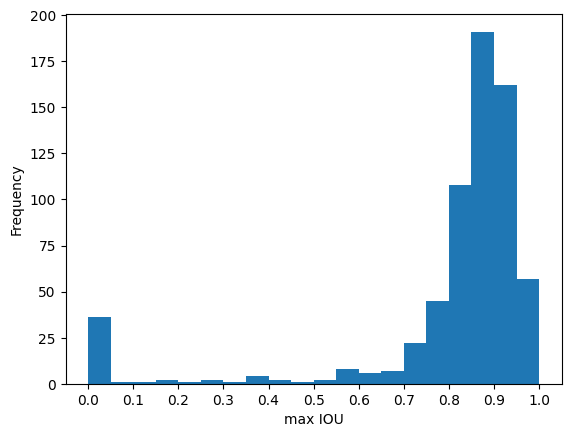

In [19]:
plt.hist(results_table_test["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

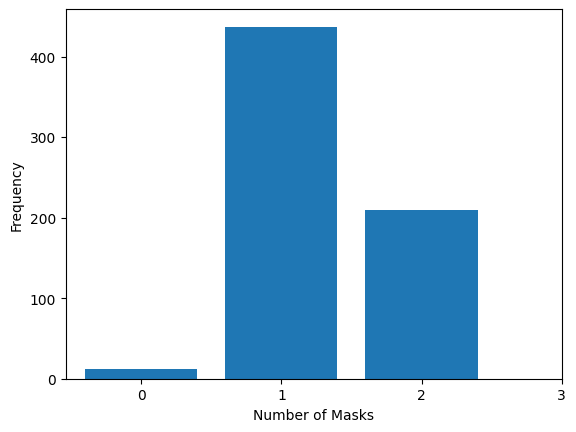

image_number       coord  \
0    data/cell_seg/cellpose_test_greyscale/024_img.png  (211, 151)   
1    data/cell_seg/cellpose_test_greyscale/024_img.png  (292, 183)   
2    data/cell_seg/cellpose_test_greyscale/024_img.png    (87, 28)   
3    data/cell_seg/cellpose_test_greyscale/024_img.png   (88, 128)   
4    data/cell_seg/cellpose_test_greyscale/024_img.png  (404, 321)   
..                                                 ...         ...   
654  data/cell_seg/cellpose_test_greyscale/060_img.png  (485, 139)   
655  data/cell_seg/cellpose_test_greyscale/060_img.png  (267, 158)   
656  data/cell_seg/cellpose_test_greyscale/060_img.png  (337, 327)   
657  data/cell_seg/cellpose_test_greyscale/060_img.png   (311, 58)   
658  data/cell_seg/cellpose_test_greyscale/060_img.png  (381, 478)   

                                         IOUs Pred Mask Pair to IOUs  \
0                  [0.8354430198669434, 0.75]    {(0, 1): 0.7816901}   
1    [0.8029850721359253, 0.7507886290550232]   {(0, 1): 0.84542584}   
2    [0.7544642686843872, 0.6713286638259888]    {(0, 1): 0.8239796}   
3    [0.8518518805503845, 0.6840277910232544]    {(0, 1): 0.7519084}   
4    [0.8965853452682495, 0.8388122916221619]    {(0, 1): 0.7902098}   
..                                        ...                    ...   
654    [0.92464679479599, 0.9600874781608582]    {(0, 1): 0.9511298}   
655  [0.8705694675445557, 0.9100374579429626]   {(0, 1): 0.95487803}   
656  [0.9775238633155823, 0.9849923849105835]    {(0, 1): 0.9791901}   
657  [0.9526493549346924, 0.9675936698913574]   {(0, 1): 0.97736627}   
658  [0.9393414258956909, 0.9358823299407959]    {(0, 1): 0.9618056}   

    Classified as Cell   max IOU Indices Classified as Cell  \
0         [True, True]  0.835443                     [0, 1]   
1         [True, True]  0.802985                     [0, 1]   
2         [True, True]  0.754464                     [0, 1]   
3         [True, True]  0.851852                     [0, 1]   
4         [True, True]  0.896585                     [0, 1]   
..                 ...       ...                        ...   
654       [True, True]  0.960087                     [0, 1]   
655       [True, True]  0.910037                     [0, 1]   
656       [True, True]  0.984992                     [0, 1]   
657       [True, True]  0.967594                     [0, 1]   
658       [True, True]  0.939341                     [0, 1]   

    Final Mask Indices  Final Mask Number  \
0               [0, 1]                  2   
1               [0, 1]                  2   
2               [0, 1]                  2   
3               [0, 1]                  2   
4               [0, 1]                  2   
..                 ...                ...   
654                [0]                  1   
655                [0]                  1   
656                [0]                  1   
657                [0]                  1   
658                [0]                  1   

                              Final Mask IOUs  Final Mask max IOU  
0                  [0.8354430198669434, 0.75]            0.835443  
1    [0.8029850721359253, 0.7507886290550232]            0.802985  
2    [0.7544642686843872, 0.6713286638259888]            0.754464  
3    [0.8518518805503845, 0.6840277910232544]            0.851852  
4    [0.8965853452682495, 0.8388122916221619]            0.896585  
..                                        ...                 ...  
654                        [0.92464679479599]            0.924647  
655                      [0.8705694675445557]            0.870569  
656                      [0.9775238633155823]            0.977524  
657                      [0.9526493549346924]            0.952649  
658                      [0.9393414258956909]            0.939341  

[659 rows x 11 columns]

In [21]:
results_table_test["Indices Classified as Cell"] = results_table_test["Classified as Cell"].apply(lambda x: np.argwhere(x)[:, 0])

indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))
results_table_test["Final Mask Indices"] = results_table_test.apply(lambda x: np.intersect1d(x["Final Mask Indices"], x["Indices Classified as Cell"]), axis=1)

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: 0 if len(x)==0 else np.max(x))

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values)
plt.xticks(np.arange(0, 4))
plt.xlabel("Number of Masks")
plt.ylabel("Frequency")
plt.show()

results_table_test

In [22]:
file = open('data/cell_seg/conformal_ious_test_cellpose_SAM_remove_duplicate_masks.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

data/cell_seg/cellpose_test_greyscale/064_img.png
MAX IOU: 0.6222109794616699
Final MAX IOU: 0.6188094019889832


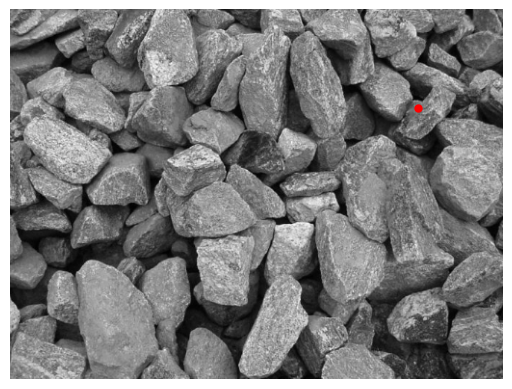

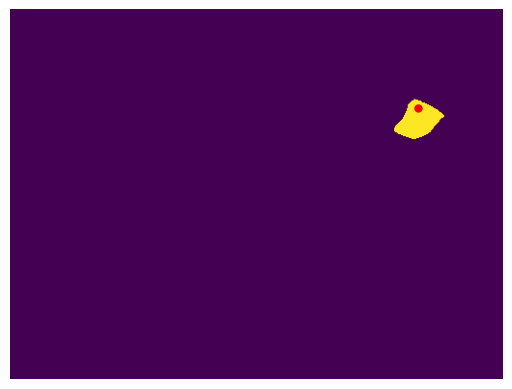

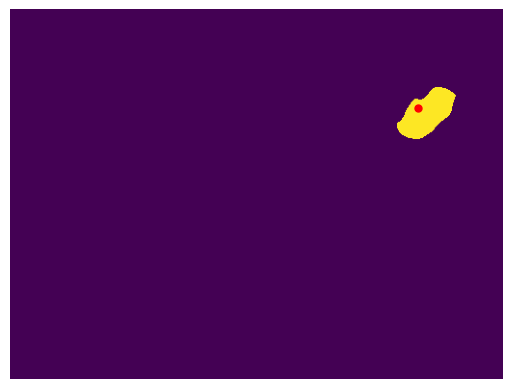

data/cell_seg/cellpose_test_greyscale/033_img.png
MAX IOU: 0.8582930564880371
Final MAX IOU: 0.8253477811813354


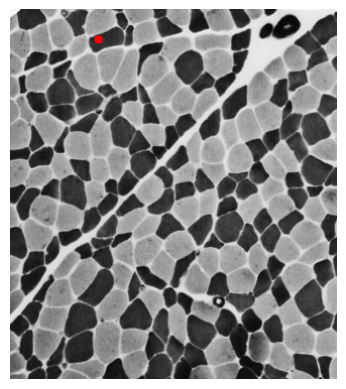

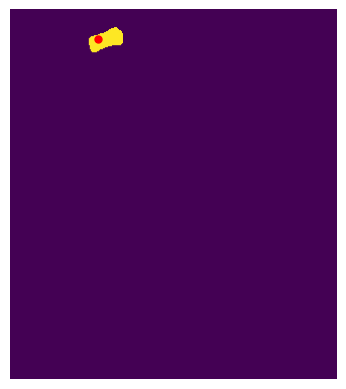

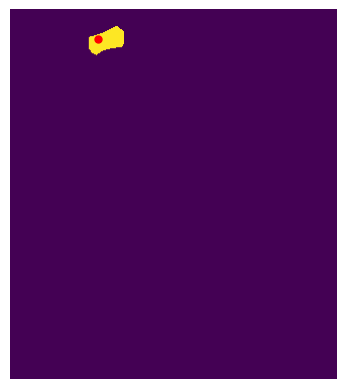

data/cell_seg/cellpose_test_greyscale/029_img.png
MAX IOU: 0.870582640171051
Final MAX IOU: 0.870582640171051


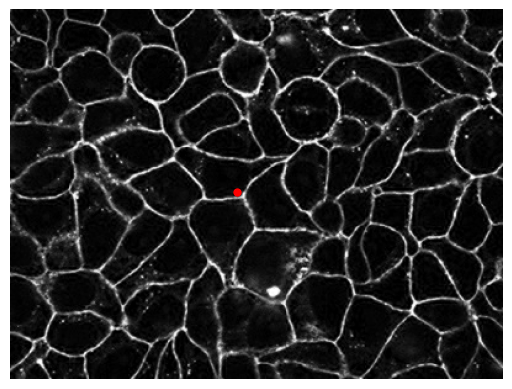

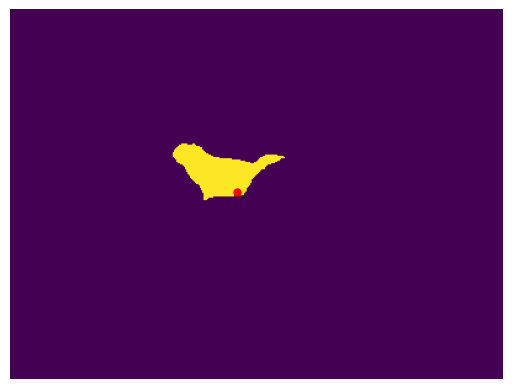

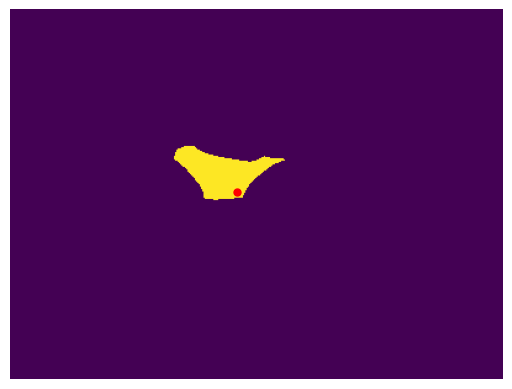

data/cell_seg/cellpose_test_greyscale/064_img.png
MAX IOU: 0.9285362362861633
Final MAX IOU: 0.9285362362861633


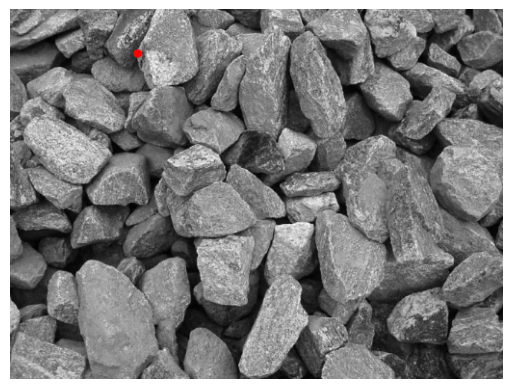

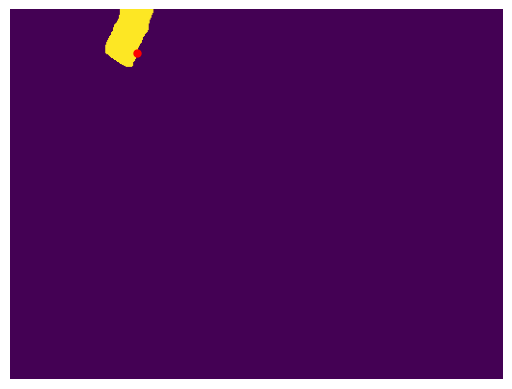

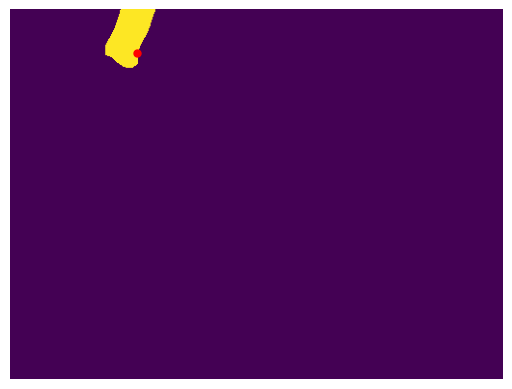

data/cell_seg/cellpose_test_greyscale/039_img.png
MAX IOU: 0.8917197585105896
Final MAX IOU: 0.8917197585105896


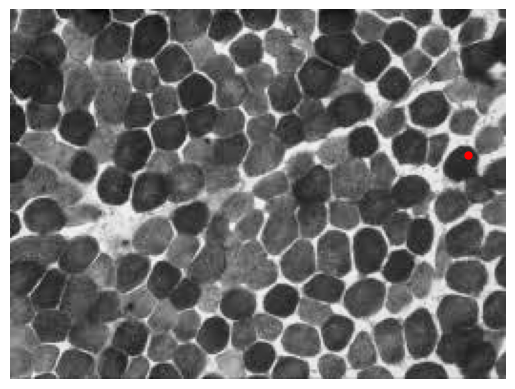

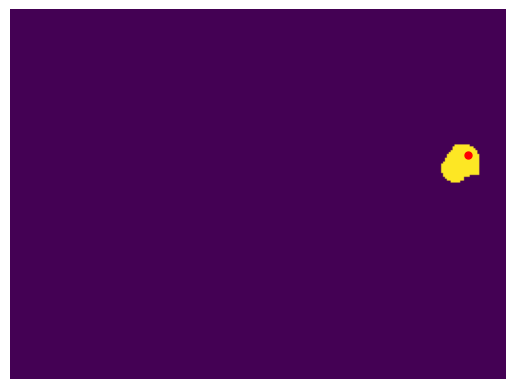

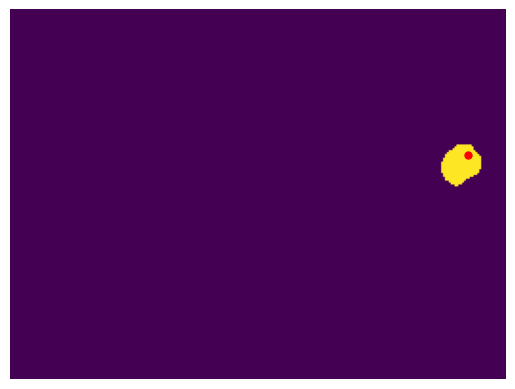

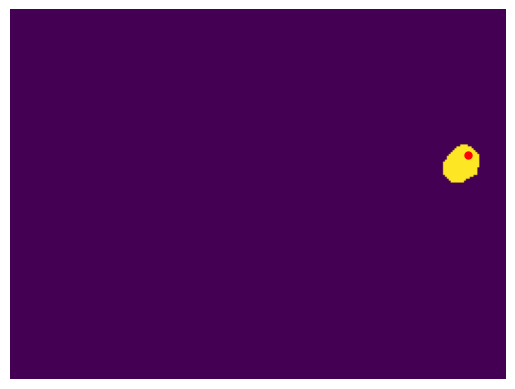

In [28]:
np.random.seed(0)

for index, row in results_table_test.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    print(image_number)
    print("MAX IOU:", row["max IOU"])
    print("Final MAX IOU:", row["Final Mask max IOU"])
    #print(coord)

    img = io.imread(image_number)[...,1]
    fig = plt.figure(frameon=False) # initialize figure
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("True Segmentation")
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    plt.show()

    #print("Confidence Set with Duplicates Removed")
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    for T in T_confidence_set_duplicates_removed:
        pred_segmentation, _, _ = detect_cells(img, T)
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()])
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.axis('off')
        plt.show()

# Update IOU threshold of conformal guarantee to incorporate removing duplicates

In [29]:
T_confidence_set

array([-2.,  0.])

In [30]:
np.random.seed(0)

points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": [], "Classified as Cell": []}
for image_number in tqdm(image_numbers_calibration):
    img = io.imread(image_number)[...,1]
    
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    pred_shapes = []
    classified_as_cell = []
    if len(coords) != 0:
        for T in T_confidence_set:
            pred_segmentation, _, _ = detect_cells(img, T)
            IOUs_T = []
            pred_shapes_T = []
            classified_as_cell_T = []
            for coord in coords:
                if pred_segmentation[coord] == 0:
                    IOU = 0 # the pixel is predicted to be a non-cell
                    pred_shape = torch.zeros(img.shape)
                    classified_as_cell_T.append(False)
                else:
                    true_shape = true_segmentation==true_segmentation[coord]
                    pred_shape = pred_segmentation==pred_segmentation[coord]
                    IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape)).numpy().item()
                    classified_as_cell_T.append(True)
                pred_shapes_T.append(pred_shape)
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
            pred_shapes.append(pred_shapes_T)
            classified_as_cell.append(classified_as_cell_T)
            
        pair_to_iou_dicts = []
        for pred_shapes_coord in torch.from_numpy(np.swapaxes(pred_shapes, 0, 1)):
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
        # store results
        results["image_number"].extend(np.repeat(image_number, len(coords)))
        results["coord"].extend(coords)
        results["IOUs"].extend(np.array(IOUs).T.tolist())
        results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)
        results["Classified as Cell"].extend(np.array(classified_as_cell).T.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:40<00:00, 59.34s/it]


In [31]:
results_table_calibration = pd.DataFrame.from_dict(results)

In [43]:
IOU_threshold = 0.75

results_table_calibration["max IOU"] = results_table_calibration["IOUs"].map(lambda x: np.max(x))
results_table_calibration_high_IOUs = results_table_calibration[results_table_calibration["max IOU"] > IOU_threshold]

coverage = len(results_table_calibration_high_IOUs) / len(results_table_calibration)
print(coverage)

0.8216216216216217


In [44]:
results_table_calibration["Indices Classified as Cell"] = results_table_calibration["Classified as Cell"].apply(lambda x: np.argwhere(x)[:, 0])

indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_calibration["Final Mask Indices"] = results_table_calibration["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))
results_table_calibration["Final Mask Indices"] = results_table_calibration.apply(lambda x: np.intersect1d(x["Final Mask Indices"], x["Indices Classified as Cell"]), axis=1)

results_table_calibration["Final Mask Number"] = results_table_calibration["Final Mask Indices"].apply(lambda x: len(x))
results_table_calibration["Final Mask IOUs"] = results_table_calibration.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_calibration["Final Mask max IOU"] = results_table_calibration["Final Mask IOUs"].map(lambda x: 0 if len(x)==0 else np.max(x))

results_table_calibration

image_number       coord  \
0    data/cell_seg/cellpose_test_greyscale/044_img.png   (172, 53)   
1    data/cell_seg/cellpose_test_greyscale/044_img.png    (47, 38)   
2    data/cell_seg/cellpose_test_greyscale/044_img.png  (117, 244)   
3    data/cell_seg/cellpose_test_greyscale/044_img.png   (67, 105)   
4    data/cell_seg/cellpose_test_greyscale/044_img.png   (103, 42)   
..                                                 ...         ...   
920  data/cell_seg/cellpose_test_greyscale/061_img.png  (324, 256)   
921  data/cell_seg/cellpose_test_greyscale/061_img.png   (95, 197)   
922  data/cell_seg/cellpose_test_greyscale/061_img.png  (106, 233)   
923  data/cell_seg/cellpose_test_greyscale/061_img.png  (242, 353)   
924  data/cell_seg/cellpose_test_greyscale/061_img.png   (91, 177)   

                                             IOUs Pred Mask Pair to IOUs  \
0        [0.7923728823661804, 0.8213762640953064]    {(0, 1): 0.9606918}   
1        [0.8606124520301819, 0.8606124520301819]          {(0, 1): 1.0}   
2    [0.005891016218811274, 0.005899704992771149]    {(0, 1): 0.9948586}   
3      [0.44285714626312256, 0.44285714626312256]          {(0, 1): 1.0}   
4        [0.8606557250022888, 0.8606557250022888]          {(0, 1): 1.0}   
..                                            ...                    ...   
920      [0.9082905650138855, 0.9336349964141846]   {(0, 1): 0.97203326}   
921      [0.7677338123321533, 0.7883495092391968]   {(0, 1): 0.96672946}   
922      [0.8950704336166382, 0.8976545929908752]   {(0, 1): 0.98512745}   
923      [0.7758169770240784, 0.8753687143325806]   {(0, 1): 0.88620013}   
924      [0.7677338123321533, 0.7883495092391968]   {(0, 1): 0.96672946}   

    Classified as Cell   max IOU Indices Classified as Cell  \
0         [True, True]  0.821376                     [0, 1]   
1         [True, True]  0.860612                     [0, 1]   
2         [True, True]  0.005900                     [0, 1]   
3         [True, True]  0.442857                     [0, 1]   
4         [True, True]  0.860656                     [0, 1]   
..                 ...       ...                        ...   
920       [True, True]  0.933635                     [0, 1]   
921       [True, True]  0.788350                     [0, 1]   
922       [True, True]  0.897655                     [0, 1]   
923       [True, True]  0.875369                     [0, 1]   
924       [True, True]  0.788350                     [0, 1]   

    Final Mask Indices  Final Mask Number  \
0                  [0]                  1   
1                  [0]                  1   
2                  [0]                  1   
3                  [0]                  1   
4                  [0]                  1   
..                 ...                ...   
920                [0]                  1   
921                [0]                  1   
922                [0]                  1   
923             [0, 1]                  2   
924                [0]                  1   

                              Final Mask IOUs  Final Mask max IOU  
0                        [0.7923728823661804]            0.792373  
1                        [0.8606124520301819]            0.860612  
2                      [0.005891016218811274]            0.005891  
3                       [0.44285714626312256]            0.442857  
4                        [0.8606557250022888]            0.860656  
..                                        ...                 ...  
920                      [0.9082905650138855]            0.908291  
921                      [0.7677338123321533]            0.767734  
922                      [0.8950704336166382]            0.895070  
923  [0.7758169770240784, 0.8753687143325806]            0.875369  
924                      [0.7677338123321533]            0.767734  

[925 rows x 11 columns]

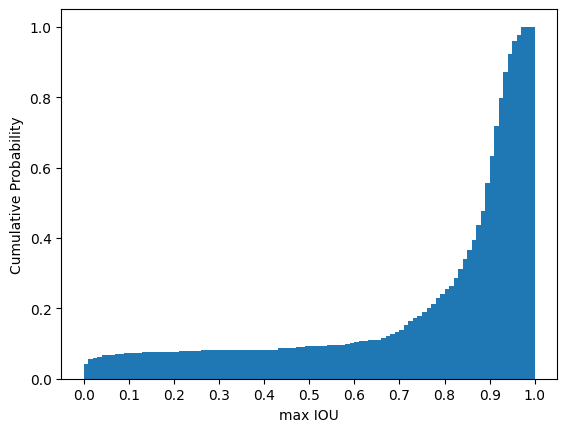

In [45]:
plt.hist(results_table_calibration["max IOU"], bins=np.arange(0, 1.01, .01), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

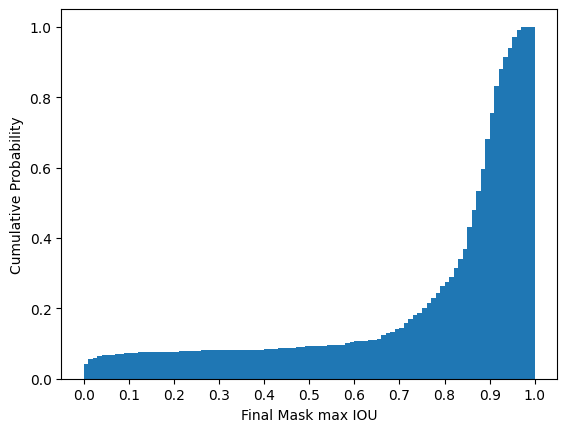

In [46]:
plt.hist(results_table_calibration["Final Mask max IOU"], bins=np.arange(0, 1.01, .01), density=True, cumulative=True)
plt.xlabel("Final Mask max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

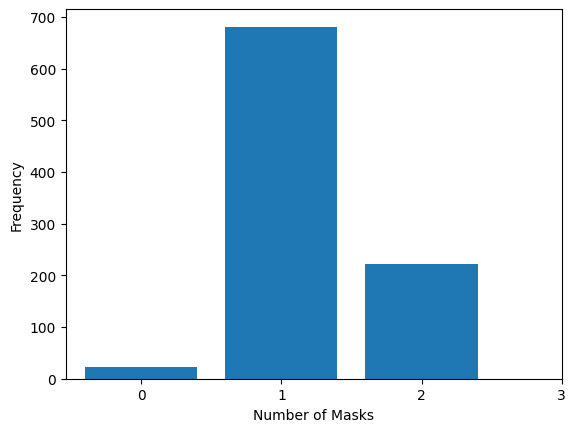

In [47]:
plt.bar(results_table_calibration['Final Mask Number'].value_counts().index, results_table_calibration['Final Mask Number'].value_counts().values)
plt.xticks(np.arange(0, 4))
plt.xlabel("Number of Masks")
plt.ylabel("Frequency")
plt.show()

In [48]:
# New IOU threshold for conformal guarantee
q = np.quantile(results_table_calibration["Final Mask max IOU"], alpha)
print(q)

0.7600278258323669


In [49]:
file = open('data/cell_seg/conformal_ious_calibration_cellpose_SAM_remove_duplicate_masks.pkl', 'wb')
pickle.dump(results_table_calibration, file)
file.close()

In [50]:
# check coverage on test set
file = open('data/cell_seg/conformal_ious_test_cellpose_SAM_remove_duplicate_masks.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

In [51]:
# Compute test set coverage after removing duplicate masks
results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > q]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.834597875569044


# Compare to test set coverage of baseline model (T=0)

In [9]:
q = 0.7600278258323669

In [6]:
file = open('data/cell_seg/conformal_ious_test_cellpose_SAM_remove_duplicate_masks.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

In [8]:
results_table_test['Baseline IOU'] = results_table_test['IOUs'].apply(lambda x: x[1])
results_table_test

image_number       coord  \
0    data/cell_seg/cellpose_test_greyscale/024_img.png  (211, 151)   
1    data/cell_seg/cellpose_test_greyscale/024_img.png  (292, 183)   
2    data/cell_seg/cellpose_test_greyscale/024_img.png    (87, 28)   
3    data/cell_seg/cellpose_test_greyscale/024_img.png   (88, 128)   
4    data/cell_seg/cellpose_test_greyscale/024_img.png  (404, 321)   
..                                                 ...         ...   
654  data/cell_seg/cellpose_test_greyscale/060_img.png  (485, 139)   
655  data/cell_seg/cellpose_test_greyscale/060_img.png  (267, 158)   
656  data/cell_seg/cellpose_test_greyscale/060_img.png  (337, 327)   
657  data/cell_seg/cellpose_test_greyscale/060_img.png   (311, 58)   
658  data/cell_seg/cellpose_test_greyscale/060_img.png  (381, 478)   

                                         IOUs Pred Mask Pair to IOUs  \
0                  [0.8354430198669434, 0.75]    {(0, 1): 0.7816901}   
1    [0.8029850721359253, 0.7507886290550232]   {(0, 1): 0.84542584}   
2    [0.7544642686843872, 0.6713286638259888]    {(0, 1): 0.8239796}   
3    [0.8518518805503845, 0.6840277910232544]    {(0, 1): 0.7519084}   
4    [0.8965853452682495, 0.8388122916221619]    {(0, 1): 0.7902098}   
..                                        ...                    ...   
654    [0.92464679479599, 0.9600874781608582]    {(0, 1): 0.9511298}   
655  [0.8705694675445557, 0.9100374579429626]   {(0, 1): 0.95487803}   
656  [0.9775238633155823, 0.9849923849105835]    {(0, 1): 0.9791901}   
657  [0.9526493549346924, 0.9675936698913574]   {(0, 1): 0.97736627}   
658  [0.9393414258956909, 0.9358823299407959]    {(0, 1): 0.9618056}   

    Classified as Cell   max IOU Indices Classified as Cell  \
0         [True, True]  0.835443                     [0, 1]   
1         [True, True]  0.802985                     [0, 1]   
2         [True, True]  0.754464                     [0, 1]   
3         [True, True]  0.851852                     [0, 1]   
4         [True, True]  0.896585                     [0, 1]   
..                 ...       ...                        ...   
654       [True, True]  0.960087                     [0, 1]   
655       [True, True]  0.910037                     [0, 1]   
656       [True, True]  0.984992                     [0, 1]   
657       [True, True]  0.967594                     [0, 1]   
658       [True, True]  0.939341                     [0, 1]   

    Final Mask Indices  Final Mask Number  \
0               [0, 1]                  2   
1               [0, 1]                  2   
2               [0, 1]                  2   
3               [0, 1]                  2   
4               [0, 1]                  2   
..                 ...                ...   
654                [0]                  1   
655                [0]                  1   
656                [0]                  1   
657                [0]                  1   
658                [0]                  1   

                              Final Mask IOUs  Final Mask max IOU  \
0                  [0.8354430198669434, 0.75]            0.835443   
1    [0.8029850721359253, 0.7507886290550232]            0.802985   
2    [0.7544642686843872, 0.6713286638259888]            0.754464   
3    [0.8518518805503845, 0.6840277910232544]            0.851852   
4    [0.8965853452682495, 0.8388122916221619]            0.896585   
..                                        ...                 ...   
654                        [0.92464679479599]            0.924647   
655                      [0.8705694675445557]            0.870569   
656                      [0.9775238633155823]            0.977524   
657                      [0.9526493549346924]            0.952649   
658                      [0.9393414258956909]            0.939341   

     Baseline IOU  
0        0.750000  
1        0.750789  
2        0.671329  
3        0.684028  
4        0.838812  
..            ...  
654      0.960087  
655      0.910037  
656      0.984992  
657      

In [10]:
results_table_test_high_IOUs = results_table_test[results_table_test["Baseline IOU"] > q]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.802731411229135


# Figures for paper

In [7]:
T_confidence_set = np.array([-2, 0])

In [12]:
q = 0.7600278258323669
tau = 0.75
alpha = 0.2

In [8]:
file = open('data/cell_seg/conformal_ious_test_cellpose_SAM_remove_duplicate_masks.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

results_table_test["Indices Classified as Cell"] = results_table_test["Classified as Cell"].apply(lambda x: np.argwhere(x)[:, 0])

indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))
results_table_test["Final Mask Indices"] = results_table_test.apply(lambda x: np.intersect1d(x["Final Mask Indices"], x["Indices Classified as Cell"]), axis=1)

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: 0 if len(x)==0 else np.max(x))

In [9]:
np.random.seed(0)

baseline_segmentations = []
confidence_sets = []
for index, row in tqdm(results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows()):
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    img = io.imread(image_number)[...,1]
    
    #print("Baseline Model Prediction")
    baseline_segmentation, _, _ = detect_cells(img, 0)
    
    #print("Confidence Set with Duplicates Removed")
    confidence_set = []
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        pred_segmentation, _, _ = detect_cells(img, T)
        confidence_set.append(pred_segmentation)

    baseline_segmentations.append(baseline_segmentation)
    confidence_sets.append(confidence_set)

5it [01:04, 12.95s/it]


data/cell_seg/cellpose_test_greyscale/064_img.png
(102, 423)
3
data/cell_seg/cellpose_test_greyscale/033_img.png
(29, 87)
3
data/cell_seg/cellpose_test_greyscale/029_img.png
(148, 184)
3
data/cell_seg/cellpose_test_greyscale/064_img.png
(45, 131)
3
data/cell_seg/cellpose_test_greyscale/039_img.png
(76, 240)
4


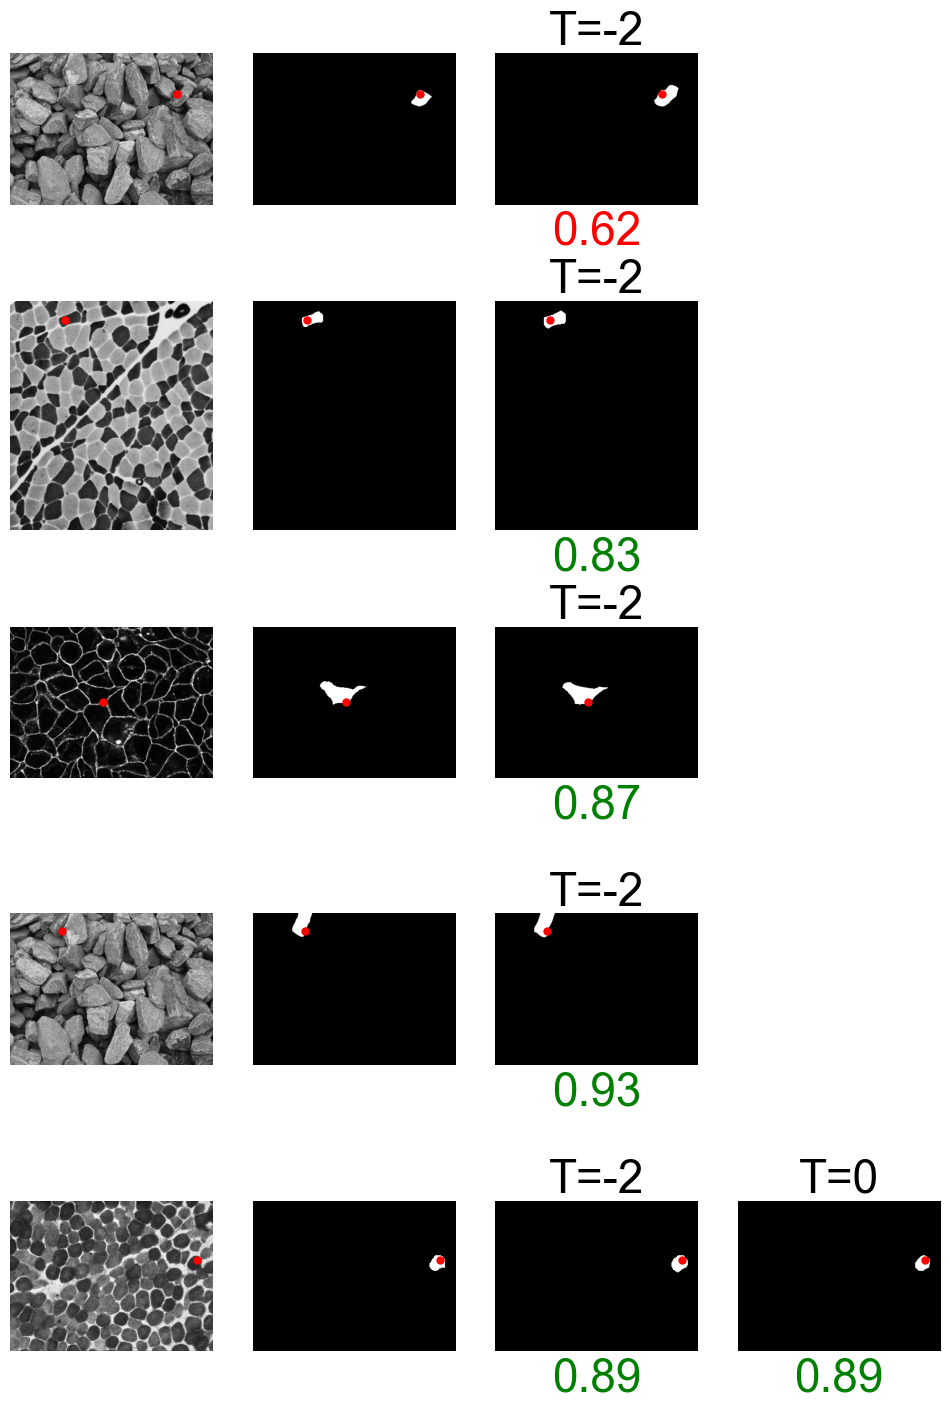

In [23]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=33)
plt.rc('axes', titlesize=33)     
plt.rc('axes', labelsize=33)
plt.rc('figure', titlesize=33)

np.random.seed(0)

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 18))

i=0
for index, row in results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    
    print(image_number)
    print(coord)

    img = io.imread(image_number)[...,1]
    plt.sca(axs[i, 0])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    
    #print("True Segmentation")
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    plt.sca(axs[i, 1])
    plt.imshow(true_segmentation==true_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Confidence Set with Duplicates Removed")
    true_shape = true_segmentation==true_segmentation[coord]
    for j, pred_segmentation in enumerate(confidence_sets[i]):
        pred_shape = pred_segmentation==pred_segmentation[coord]
        IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape)).numpy().item()
        
        plt.sca(axs[i, 2+j])
        #plt.axis('off')
        plt.imshow(pred_segmentation==pred_segmentation[coord], cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        #plt.title(f"{np.round(IOU, 2):.2f}", y=-0.35)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        plt.title(f"T={T_confidence_set_duplicates_removed[j]}")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    print(2+len(T_confidence_set_duplicates_removed))
    for j in range(2+len(T_confidence_set_duplicates_removed), 4):
        axs[i, j].axis('off')

    i += 1
plt.savefig('plots/cell-segmentation-examples.png', dpi=300, bbox_inches='tight')
plt.show()

data/cell_seg/cellpose_test_greyscale/041_img.png
(40, 302)
4


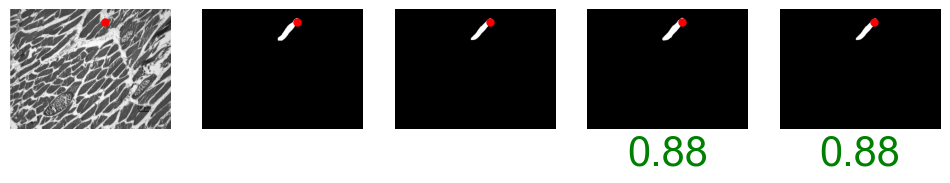

In [29]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=30)
plt.rc('axes', titlesize=30)     
plt.rc('axes', labelsize=30)
plt.rc('figure', titlesize=30)

np.random.seed(0)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2))

i=0
for index, row in results_table_test[results_table_test["Final Mask Number"]==2].sample(n=1).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    
    print(image_number)
    print(coord)

    img = io.imread(image_number)[...,1]
    plt.sca(axs[0])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    
    #print("True Segmentation")
    true_segmentation = io.imread(image_number[:-7]+'masks.png')
    plt.sca(axs[1])
    plt.imshow(true_segmentation==true_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Baseline Model Prediction")
    plt.sca(axs[2])
    baseline_segmentation, _, _ = detect_cells(img, 0)
    plt.imshow(baseline_segmentation==baseline_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Confidence Set with Duplicates Removed")
    true_shape = true_segmentation==true_segmentation[coord]
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        pred_segmentation, _, _ = detect_cells(img, T)
        pred_shape = pred_segmentation==pred_segmentation[coord]
        IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape)).numpy().item()
        
        plt.sca(axs[3+j])
        #plt.axis('off')
        plt.imshow(pred_segmentation==pred_segmentation[coord], cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        #plt.title(f"{np.round(IOU, 2):.2f}", y=-0.35)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        #plt.title(f"T={T_confidence_set_duplicates_removed[j]}")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    print(2+len(T_confidence_set_duplicates_removed))
    for j in range(3+len(T_confidence_set_duplicates_removed), 5):
        axs[j].axis('off')

    i += 1
plt.savefig('plots/cell-segmentation-single-example.png', dpi=300, bbox_inches='tight')
plt.show()

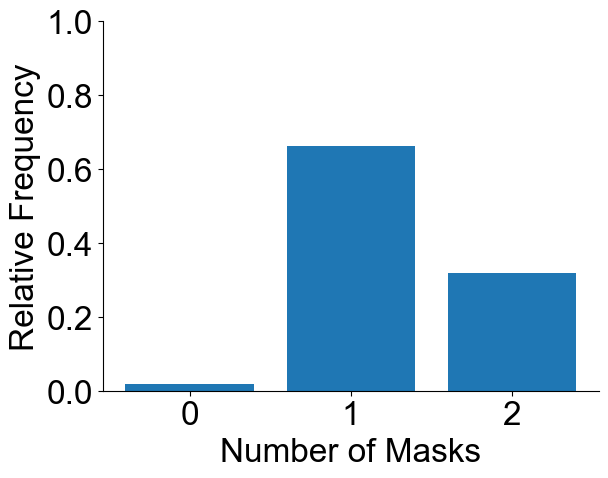

In [31]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values/len(results_table_test))
plt.xticks(np.arange(0, 3))
plt.ylim([0, 1])
plt.xlabel("Number of Masks")
plt.ylabel("Relative Frequency")
plt.show()

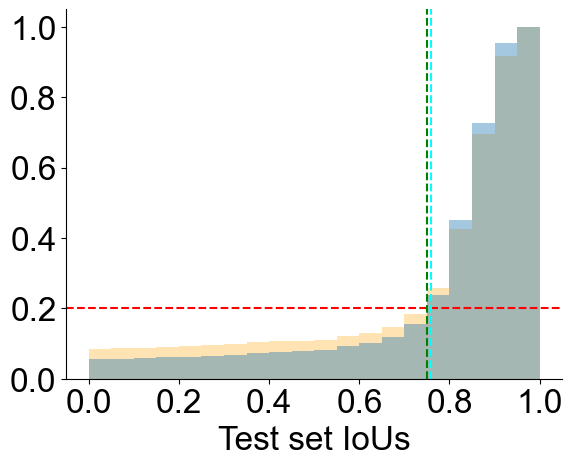

In [34]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

results_table_test['Baseline IOU'] = results_table_test['IOUs'].apply(lambda x: x[1])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(results_table_test['Baseline IOU'], bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.3, label='baseline', color='orange')
plt.hist(results_table_test["Final Mask max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.4, label='conformal')
plt.xlabel("Test set IoUs")
#plt.ylabel("Cumulative Frequency")
plt.xticks(np.arange(0, 1.01, 0.2))
plt.yticks(np.arange(0, 1.01, 0.2))
plt.axhline(alpha, color='red', linestyle='dashed', label=r'$\alpha$')
plt.axvline(tau, color='green', linestyle='dashed', label=r'$\tau$')
plt.axvline(q, color='cyan', linestyle='dashed', label=r'$\theta$')
#plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()